Code for Merging Respiratory and Behavioral Data

Overview

This script integrates respiratory recordings with behavioral event data to analyze respiratory dynamics during specific behavioral bouts. It processes raw data, synchronizes it with behavioral events, and performs analyses.

Workflow Explanation
1. Import Libraries
Essential libraries used in the script:

tdt: Reads and processes TDT system data.

neurokit2: Cleans and extracts features from respiratory signals.

numpy and pandas: Handle numerical computations and structured tabular data.

matplotlib: Visualizes respiratory data alongside behavioral events.

2. Load Respiratory Data
Purpose: Extract and prepare the respiratory signal for analysis.

Steps:

Load respiratory signal data from the TDT block.

Extract the signal and its sampling rate.

Generate a time vector for synchronization and plotting.

3. Process Respiratory Signal
Purpose: Preprocess the respiratory signal for analysis.

Key Functions:

nk.rsp_clean: Cleans the raw respiratory signal to remove noise.

nk.rsp_rate: Calculates respiratory rate (breaths per minute).

signal_filter: Smooths the respiratory rate for improved clarity.

Outcome: A DataFrame containing time, respiratory rate, and cleaned signal.

4. Extract Behavioral Bouts
Purpose: Identify and extract periods of specific behavioral activities.

How It Works:

A function identifies behavioral bouts based on input parameters:

Subject: Specifies which subject(s) to analyze.

Behavior: Defines target behaviors (e.g., running, grooming).

Filters:

min_iti: Minimum time between bouts.

min_bout: Minimum bout duration.

Filters out irrelevant or short bouts.

Example Use: Demonstrates the extraction of "running" bouts for a specific subject.

5. Align Respiratory and Behavioral Data
Purpose: Synchronize respiratory signals with behavioral bouts.

Steps:

Flag respiratory data points that occur during behavioral bouts.

Split the data into two groups:

In-bout data: Data points during behavioral events.

Out-of-bout data: Data points outside behavioral events.

6. Analyze and Compare Data
Purpose: Compare respiratory dynamics during and outside of behavioral bouts.

Analysis:

Calculate the average respiratory rate for in-bout and out-of-bout data.

Quantify differences in respiratory behavior across contexts.

7. Visualize Results
Purpose: Present respiratory data and behavioral events visually.

Visualization Details:

Plot the respiratory signal over time.

Highlight behavioral bouts as shaded regions.

Add labels, titles, and legends for clarity.

8. Export Data
Purpose: Save processed data for further analysis or sharing.

Output: Exports a CSV file containing the merged respiratory and behavioral data.

Flexibility:

Handles multiple subjects, behaviors, and experimental conditions by adjusting parameters.

Extensions:

Analyze amplitude or phase of the respiratory signal.

Compare respiratory dynamics across different behaviors or environments.

Visualization:

Highlighting behavioral bouts enhances interpretability.

Provides insights into the interaction between respiration and behavior over time.

In [162]:
# Verify library versions
import tdt
import neurokit2 as nk
from neurokit2 import signal_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("TDT version:", tdt.__version__)
print("NeuroKit2 version:", nk.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)


TDT version: 0.6.6
NeuroKit2 version: 0.2.10
NumPy version: 1.26.4
Pandas version: 2.2.3
Matplotlib version: 3.10.0


In [163]:
import tdt

# Specify the TDT file path
tdt_file_path = r"C:\Users\ADMIN\Desktop\Code\thomas\1_1_novel_cd1_trial2"

# Load the TDT block
cagemate = tdt.read_block(tdt_file_path)

# Print the data structure to explore it
print(cagemate)


Found Synapse note file: C:\Users\ADMIN\Desktop\Code\thomas\1_1_novel_cd1_trial2\Notes.txt
read from t=0s to t=298.44s
epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])


In [164]:
print(f"streams data: {cagemate.streams.keys()}")
print(f"info data: {cagemate.info.keys()}")
print(f"epocs data: {cagemate.epocs.keys()}")
print(f"scalar data: {cagemate.scalars.keys()}")
print(f"snips data: {cagemate.snips.keys()}")

streams data: dict_keys(['Resp'])
info data: dict_keys(['tankpath', 'blockname', 'start_date', 'utc_start_time', 'stop_date', 'utc_stop_time', 'duration', 'stream_channel', 'snip_channel', 'experiment', 'subject', 'user', 'start', 'stop'])
epocs data: dict_keys(['Cam1', 'Tick'])
scalar data: dict_keys([])
snips data: dict_keys([])


In [165]:
print(dir(cagemate.streams['Resp']))

['__bool__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'channel', 'clear', 'code', 'copy', 'data', 'dform', 'fromkeys', 'fs', 'get', 'items', 'keys', 'name', 'pop', 'popitem', 'setdefault', 'size', 'start_time', 'type', 'type_str', 'ucf', 'update', 'values']


In [166]:
resp_stream = cagemate.streams['Resp']

# Extract key attributes
resp_data = resp_stream.data
fs = resp_stream.fs
start_time = resp_stream.start_time
data_shape = resp_stream.data.shape
size = resp_stream.size
channel = resp_stream.channel
stream_name = resp_stream.name

In [167]:
# Inspect the values of potentially of the attributes
print(f"Sampling Frequency (fs): {resp_stream.fs}")
print(f"Start Time: {resp_stream.start_time}")
print(f"Data Shape: {resp_stream.data.shape}")
print(f"Size: {size}")
print(f"Channel Info: {resp_stream.channel}")
print(f"Stream Type: {resp_stream.type}")
print(f"Stream Type String: {resp_stream.type_str}")
print(f"Stream Size: {resp_stream.size}")
print(f"Resp rate: {resp_data}")


Sampling Frequency (fs): 101.72525787353516
Start Time: 0.0
Data Shape: (30352,)
Size: 18
Channel Info: [1]
Stream Type: 33025
Stream Type String: streams
Stream Size: 18
Resp rate: [0.06622415 0.07232776 0.07049668 ... 0.15045395 0.14862287 0.14312962]


Created timestamps using the total number of samples and the 
sample frequency to increment each timestamp by the sampling frequency. 
Timestamp[i] = start_time + i/fs

In [168]:
# Reconstructing timestamps
num_samples = resp_data.shape[0]
timestamps = [(start_time + i) / fs for i in range(num_samples)]

In [169]:
# Make dataframe extracting resp signal and adding timestamps
resp_df = pd.DataFrame({
    'Time (s)': timestamps,
    'Respiration Signal': resp_data
})

resp_df.to_csv(r'C:\Users\ADMIN\Desktop\Code\researchProjs\respiratory_pilot\data\resp_stream.csv', index=False)
resp_df.head()

,Time (s),Respiration Signal
0,0.000000,0.066224
1,0.009830,0.072328
2,0.019661,0.070497
3,0.029491,0.057984
4,0.039322,0.057679


In [170]:
rsp_signals, info = nk.rsp_process(resp_df['Respiration Signal'], sampling_rate=fs)
rsp_signals.head(5)

,RSP_Raw,RSP_Clean,RSP_Amplitude,RSP_Rate,RSP_RVT,RSP_Phase,RSP_Phase_Completion,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Peaks,RSP_Troughs
0,0.066224,-0.052940,0.008904,50.351516,0.073548,NaN,0.0,0.441176,0.608696,0,0
1,0.072328,-0.054697,0.008904,50.351516,0.073542,NaN,0.0,0.441176,0.608696,0,0
2,0.070497,-0.056444,0.008904,50.351516,0.073534,NaN,0.0,0.441176,0.608696,0,0
3,0.057984,-0.058169,0.008904,50.351516,0.073521,NaN,0.0,0.441176,0.608696,0,0
4,0.057679,-0.059855,0.008904,50.351516,0.073506,NaN,0.0,0.441176,0.608696,0,0


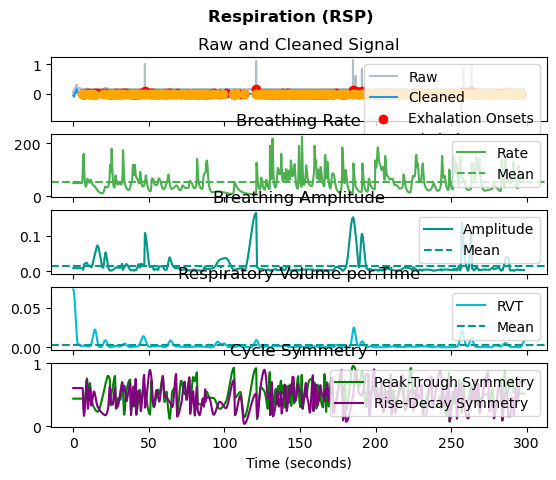

In [171]:
nk.rsp_plot(rsp_signals, info)

In [172]:
# Adding timestamps to processed resp data
rsp_signals['time'] = resp_df['Time (s)']

# Filtering from 2:02 to 2:26
interaction_signals = rsp_signals[(rsp_signals['time'] >= 122) & (rsp_signals['time'] <= 146)]
interaction_signals.head(5)

,RSP_Raw,RSP_Clean,RSP_Amplitude,RSP_Rate,RSP_RVT,RSP_Phase,RSP_Phase_Completion,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Peaks,RSP_Troughs,time
12411,0.149538,0.001638,0.010288,63.369546,0.007324,0.0,0.222222,0.156804,0.178283,0,0,122.005097
12412,0.152895,0.001661,0.010241,62.676983,0.007284,0.0,0.227273,0.158484,0.179686,0,0,122.014928
12413,0.143130,0.001691,0.010195,61.995250,0.007243,0.0,0.232323,0.160193,0.181116,0,0,122.024758
12414,0.144045,0.001728,0.010149,61.324241,0.007202,0.0,0.237374,0.161932,0.182570,0,0,122.034589
12415,0.144961,0.001770,0.010103,60.663845,0.007161,0.0,0.242424,0.163699,0.184050,0,0,122.044419


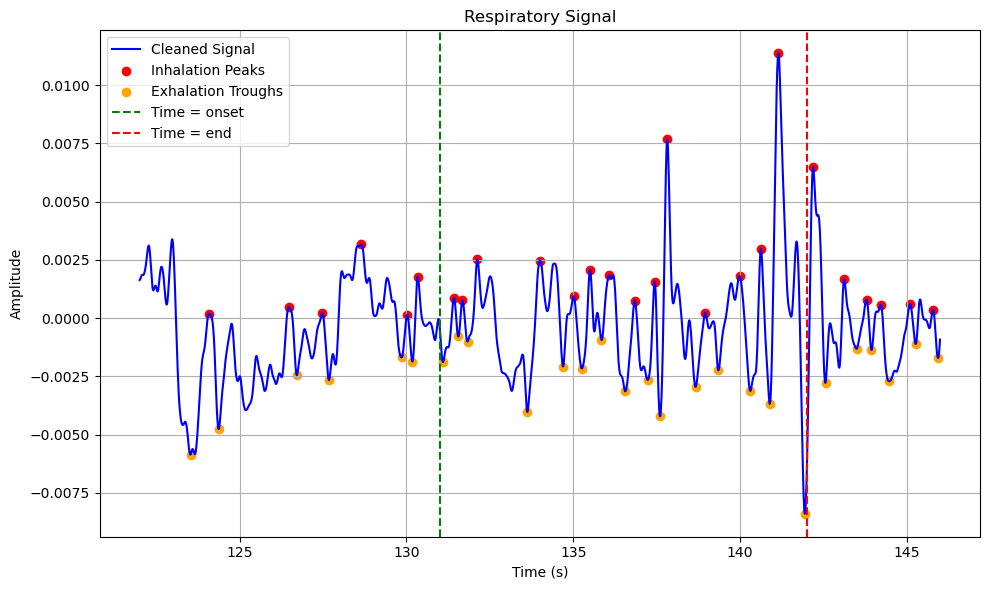

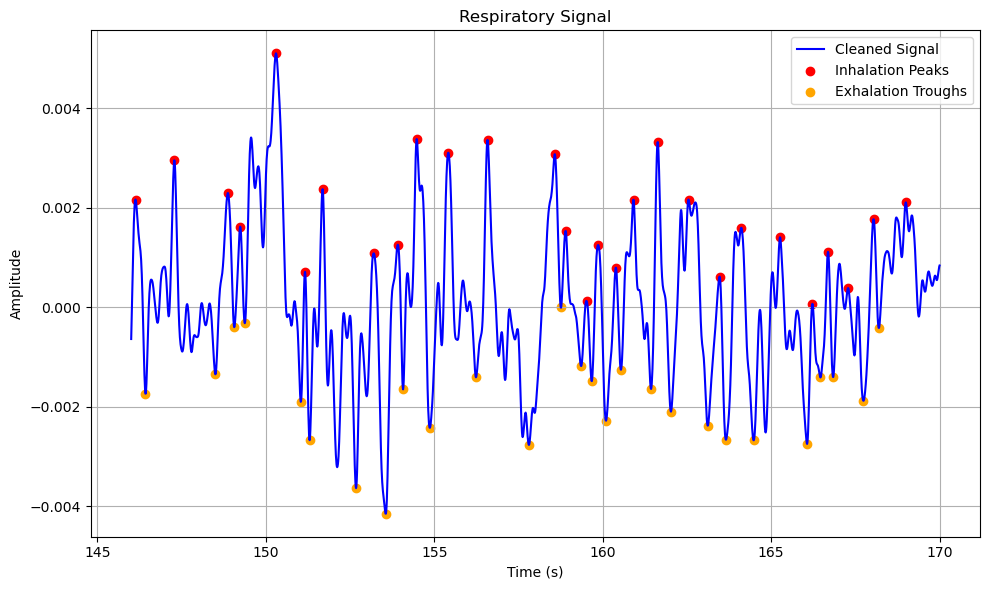

In [184]:
import resp_plotting
import importlib
importlib.reload(resp_plotting)

# Columns from time of interaction (Facial Sniffing)
inter_time = interaction_signals["time"]
inter_signals = interaction_signals["RSP_Clean"]
inter_peaks = interaction_signals["RSP_Peaks"]  # Inhalation peaks
inter_troughs = interaction_signals["RSP_Troughs"]  # Exhalation troughs


# Filtering signals from 2:26 to 2:50
roaming_signals = rsp_signals[(rsp_signals['time'] >= 146) & (rsp_signals['time'] <= 170)]

# Columns from time of roaming
roam_time = roaming_signals["time"]
roam_signals = roaming_signals["RSP_Clean"]
roam_peaks = roaming_signals["RSP_Peaks"]  # Inhalation peaks
roam_troughs = roaming_signals["RSP_Troughs"]  # Exhalation troughs

resp_plotting.resp_plot(inter_signals, inter_time, inter_peaks, inter_troughs, onset=131, end=142)

resp_plotting.resp_plot(roam_signals, roam_time, roam_peaks, roam_troughs)
